In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib as plt # plotting purposes
import seaborn as sns#plotting purposes
from sklearn.preprocessing import LabelEncoder,OneHotEncoder# encoding purposes
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/playground-series-s3e17/sample_submission.csv
/kaggle/input/playground-series-s3e17/train.csv
/kaggle/input/playground-series-s3e17/test.csv


In [2]:
sample_submission=pd.read_csv("/kaggle/input/playground-series-s3e17/sample_submission.csv")
training_set=pd.read_csv("/kaggle/input/playground-series-s3e17/train.csv")
testing_set=pd.read_csv("/kaggle/input/playground-series-s3e17/test.csv")

In [3]:
print("sample_submission", sample_submission.columns)
print("training_set", training_set.columns)
print("testing_set", testing_set.columns)

sample_submission Index(['id', 'Machine failure'], dtype='object')
training_set Index(['id', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF',
       'RNF'],
      dtype='object')
testing_set Index(['id', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'],
      dtype='object')


# **Data Prep**

In [4]:
training_set.head(10)

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0
5,5,M24300,M,298.4,308.9,1429,42.1,65,0,0,0,0,0,0
6,6,L56736,L,299.6,311.0,1413,42.9,156,0,0,0,0,0,0
7,7,L55488,L,298.7,310.1,1609,38.1,67,0,0,0,0,0,0
8,8,L56397,L,297.7,308.8,1578,35.2,13,0,0,0,0,0,0
9,9,L55067,L,300.5,312.3,1447,53.3,98,0,0,0,0,0,0


In [5]:
training_set.tail(10)

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
136419,136419,M21064,M,300.9,310.9,1523,41.4,111,0,0,0,0,0,0
136420,136420,L56888,L,299.0,310.1,1370,50.9,84,0,0,0,0,0,0
136421,136421,L56507,L,298.5,309.2,1504,33.7,18,0,0,0,0,0,0
136422,136422,L51411,L,302.2,310.8,1515,42.9,54,0,0,0,0,0,0
136423,136423,M17346,M,298.9,308.6,1375,57.5,177,0,0,0,0,0,0
136424,136424,M22284,M,300.1,311.4,1530,37.5,210,0,0,0,0,0,0
136425,136425,H38017,H,297.5,308.5,1447,49.1,2,0,0,0,0,0,0
136426,136426,L54690,L,300.5,311.8,1524,38.5,214,0,0,0,0,0,0
136427,136427,L53876,L,301.7,310.9,1447,46.3,42,0,0,0,0,0,0
136428,136428,L47937,L,296.9,308.1,1557,39.3,229,0,0,0,0,0,0


In [6]:
training_set.shape

(136429, 14)

In [7]:
training_set.isna().sum()

id                         0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64

In [8]:
#skewness value should be within the range of -1 to 1 for a normal distribution
training_set.skew()

/tmp/ipykernel_20/2158944124.py:2: FutureWarning: The default value of numeric_only in DataFrame.skew is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  training_set.skew()


id                          0.000000
Air temperature [K]         0.161175
Process temperature [K]     0.057088
Rotational speed [rpm]      1.888250
Torque [Nm]                -0.028963
Tool wear [min]            -0.027310
Machine failure             7.780216
TWF                        25.309063
HDF                        13.813058
PWF                        20.352532
OSF                        15.800499
RNF                        20.975301
dtype: float64

<Axes: >

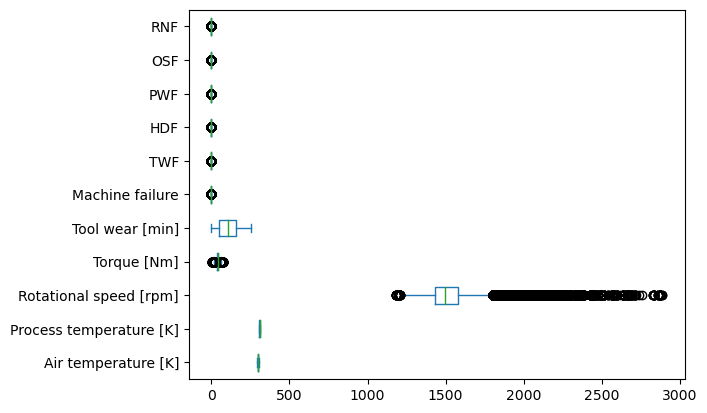

In [9]:
training_set.pop('id')
training_set.plot.box(vert=False)

<Axes: >

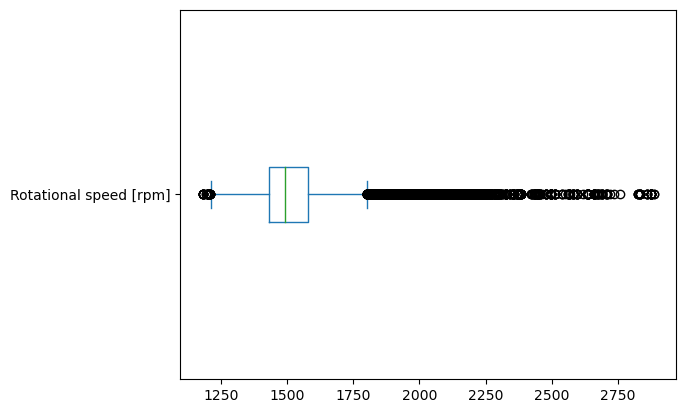

In [10]:
training_set['Rotational speed [rpm]'].plot.box(vert=False)

<Axes: >

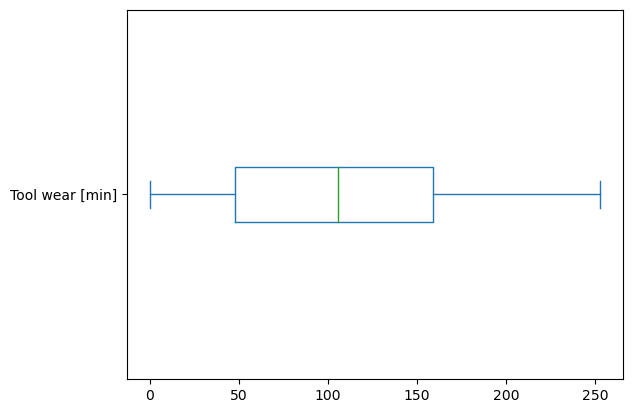

In [11]:
training_set['Tool wear [min]'].plot.box(vert=False)

<Axes: >

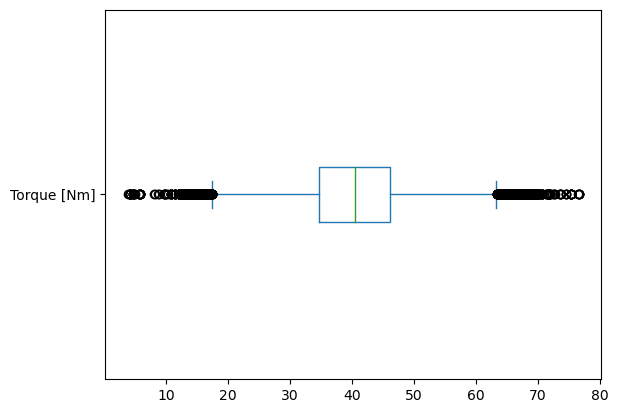

In [12]:
training_set['Torque [Nm]'].plot.box(vert=False)

<Axes: >

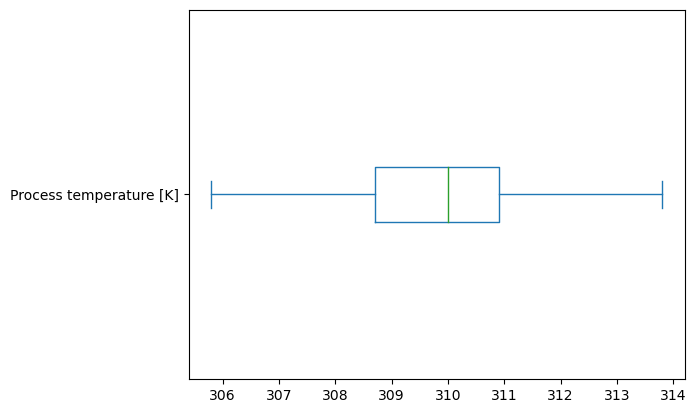

In [13]:
training_set['Process temperature [K]'].plot.box(vert=False)

In [14]:
#Outlier Removal
def outlier_removal(column_name, table):
    Q1 = column_name.quantile(0.265)
    Q3 = column_name.quantile(0.73)
    IQR = Q3 - Q1
    whisker_width = 1.5
    lower_whisker = Q1 - (whisker_width*IQR)
    upper_whisker = Q3 + (whisker_width*IQR)
    index=column_name[(column_name>upper_whisker)|(column_name<lower_whisker)].index
    table.drop(index,inplace=True)


<Axes: >

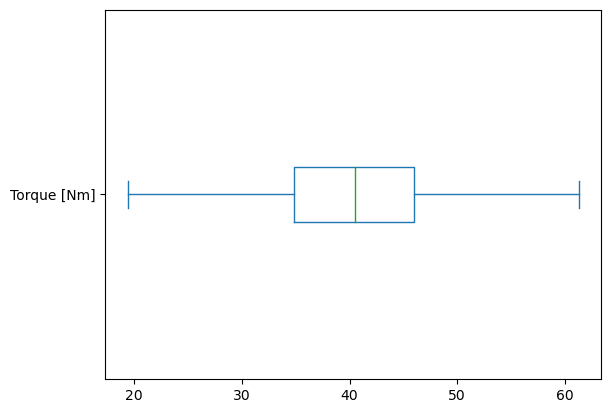

In [15]:
outlier_removal(training_set['Torque [Nm]'],training_set)
training_set['Torque [Nm]'].plot.box(vert=False)


<Axes: >

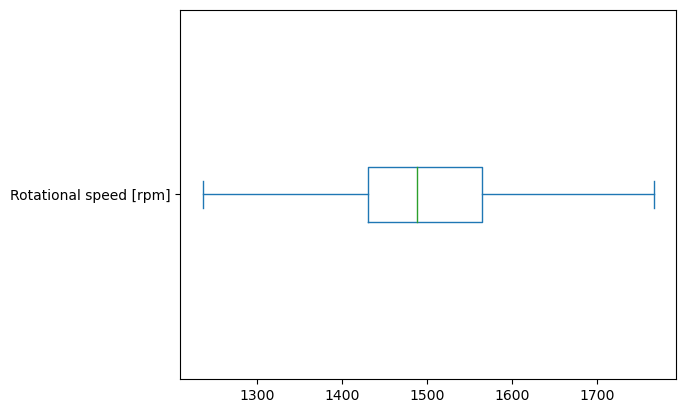

In [16]:
outlier_removal(training_set['Rotational speed [rpm]'],training_set)
training_set['Rotational speed [rpm]'].plot.box(vert=False)


In [17]:
training_set.shape

(128663, 13)

0.40571745584643526

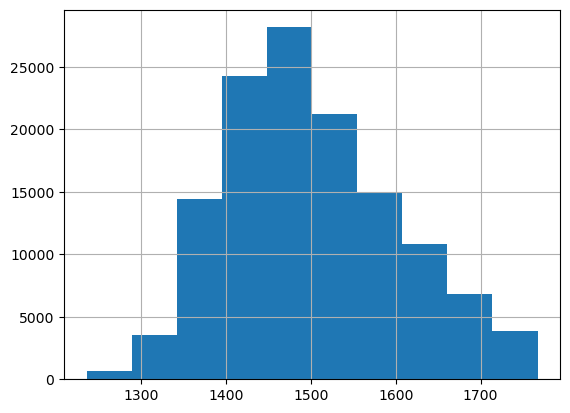

In [18]:
training_set['Rotational speed [rpm]'].hist()
training_set['Rotational speed [rpm]'].skew() #skewness value should be within the range of -1 to 1 for a normal distribution

0.13089947208371033

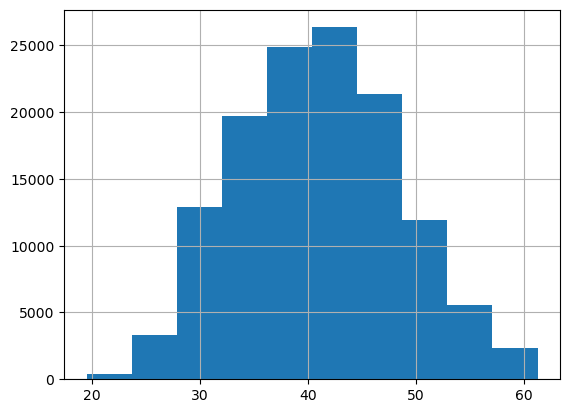

In [19]:
training_set['Torque [Nm]'].hist()
training_set['Torque [Nm]'].skew() 

25.896822124952877

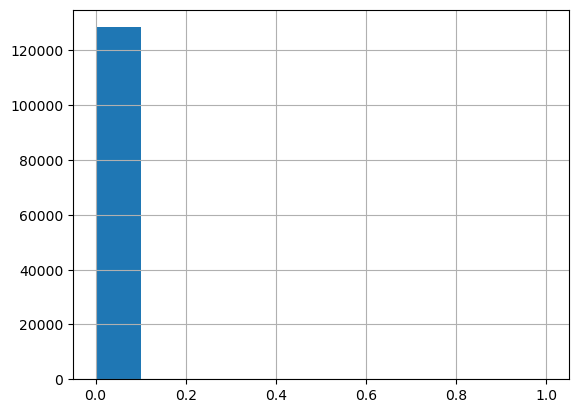

In [20]:
training_set['TWF'].hist()
training_set['TWF'].skew() 

## **Encoding Categorical Data**

In [21]:
training_set.dtypes


Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Machine failure              int64
TWF                          int64
HDF                          int64
PWF                          int64
OSF                          int64
RNF                          int64
dtype: object

In [22]:
categorical_column=['Type']
# label_encoder object
label_encoder =LabelEncoder()
# Encode labels in column. 

for i in categorical_column:
  print(i)
  training_set[i]= label_encoder.fit_transform(training_set[i])


Type


In [23]:
training_set.head()

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,L50096,1,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,M20343,2,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
3,L53355,1,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,M24050,2,298.0,309.0,1641,35.4,34,0,0,0,0,0,0
5,M24300,2,298.4,308.9,1429,42.1,65,0,0,0,0,0,0


In [24]:
training_set['Machine failure'].unique()


array([0, 1])

# **Model Benchmarking**

In [25]:
########## Split Features and Target Varible ############
X = training_set.drop(columns=['Machine failure','Product ID'])
y = training_set['Machine failure']

################# Splitting into Train -Test Data #######

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,stratify =y,random_state =42)

In [26]:
X_test.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF
68417,1,297.7,308.7,1479,40.6,118,0,0,0,0,0
36655,1,299.5,310.8,1571,38.4,74,0,0,0,0,0
51165,1,302.4,310.4,1272,54.6,68,0,1,0,1,0
82153,1,301.8,310.0,1742,30.3,185,0,0,0,0,0
53955,1,298.5,309.7,1634,41.1,78,0,0,0,0,0


In [27]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(115796, 11)
(12867, 11)
(115796,)
(12867,)


In [28]:
tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train,y_train)
y_pred = tree_clf.predict(X_test)
print("Training Data Set Accuracy: ", accuracy_score(y_test,y_pred))
print("Training Data F1 Score ", f1_score(y_test,y_pred))

print("Test Accuracy: ",accuracy_score(y_test,y_pred))
print("Test F1 Score: ",f1_score(y_test,y_pred))
print("Confusion Matrix on Test Data")
pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)

Training Data Set Accuracy:  0.9940934172689827
Training Data F1 Score  0.776470588235294
Test Accuracy:  0.9940934172689827
Test F1 Score:  0.776470588235294
Confusion Matrix on Test Data


Predicted,0,1,All
Actual,,,
0,12659,45,12704
1,31,132,163
All,12690,177,12867


In [29]:
Ann_clf = MLPClassifier(hidden_layer_sizes=(256,128,64,32),activation="relu",random_state=1)
Ann_clf.fit(X_train, y_train)
y_pred = Ann_clf.predict(X_test)
print("Training Data Set Accuracy: ", accuracy_score(y_test,y_pred))
print("Training Data F1 Score ", f1_score(y_test,y_pred))

print("Test Accuracy: ",accuracy_score(y_test,y_pred))
print("Test F1 Score: ",f1_score(y_test,y_pred))
print("Confusion Matrix on Test Data")
pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)

Training Data Set Accuracy:  0.997357581409808
Training Data F1 Score  0.8835616438356165
Test Accuracy:  0.997357581409808
Test F1 Score:  0.8835616438356165
Confusion Matrix on Test Data


Predicted,0,1,All
Actual,,,
0,12704,0,12704
1,34,129,163
All,12738,129,12867


In [30]:
XGBmodel = XGBClassifier(objective='binary:logistic',
                          booster='gbtree',
                          eval_metric='auc',
                          tree_method='hist',
                          grow_policy='lossguide')
XGBmodel.fit(X_train.to_numpy(), y_train.to_numpy())
y_pred = XGBmodel.predict(X_test)
print("Training Data Set Accuracy: ", accuracy_score(y_test,y_pred))
print("Training Data F1 Score ", f1_score(y_test,y_pred))

print("Test Accuracy: ",accuracy_score(y_test,y_pred))
print("Test F1 Score: ",f1_score(y_test,y_pred))
print("Confusion Matrix on Test Data")
pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)

Training Data Set Accuracy:  0.9975130177974664
Training Data F1 Score  0.891156462585034
Test Accuracy:  0.9975130177974664
Test F1 Score:  0.891156462585034
Confusion Matrix on Test Data


Predicted,0,1,All
Actual,,,
0,12704,0,12704
1,32,131,163
All,12736,131,12867


Best Performing model is the XGBoost

# **Mini Pipeline Function**

In [31]:
def mini_pipeline(dataset, model):
    #Data Prep
        
    #Outlier Removal
    out_columns=["Torque [Nm]","Rotational speed [rpm]"] 
    for i in dataset.columns :
        for j in out_columns:
            if (i==j):
                Q1 = dataset[f"{i}"].quantile(0.265)
                Q3 = dataset[f"{i}"].quantile(0.73)
                IQR = Q3 - Q1
                whisker_width = 1.5
                lower_whisker = Q1 - (whisker_width*IQR)
                upper_whisker = Q3 + (whisker_width*IQR)
                index=dataset[f"{i}"][(dataset[f"{i}"]>upper_whisker)|(dataset[f"{i}"]<lower_whisker)].index
                dataset.drop(index,inplace=True)
                print('Outlier treated',dataset[f"{i}"])
                
 
    # Encode labels in column.     
    categorical_column=['Type']
    
    label_encoder = LabelEncoder()
   

    for k in categorical_column:
        for l in (dataset.columns):
            if k==l:
                dataset[f"{k}"]= label_encoder.fit_transform(dataset[f"{k}"])
            
                  
    id_list=list(dataset['Product ID'])        
    X_pred=dataset.drop(columns=['id','Product ID'], axis=1)
    
       
    #Model predictions
    Machine_Fail = model.predict(X_pred)

    #returns submission
    submission=pd.DataFrame(list(zip(id_list,Machine_Fail)),columns=['id','Machine failure'])
    print(submission.head())
        
    submission.to_csv("sams_submission.csv", index=False) 
    

In [32]:
mini_pipeline(testing_set,XGBmodel)

Outlier treated 0        1499
1        1713
2        1525
3        1479
4        1515
         ... 
90949    1484
90950    1542
90951    1501
90952    1534
90953    1534
Name: Rotational speed [rpm], Length: 86476, dtype: int64
Outlier treated 0        38.0
1        28.8
2        37.7
3        47.6
4        41.3
         ... 
90949    40.4
90950    33.8
90951    41.4
90952    40.3
90953    36.1
Name: Torque [Nm], Length: 85573, dtype: float64
       id  Machine failure
0  L50896                0
1  L53866                0
2  L50498                0
3  M21232                0
4  M19751                0
